<a href="https://colab.research.google.com/github/LeJamon/BTC_trading_strategy_XgBoost/blob/main/BTC_trading_strategy_XgBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction 
Le but de ce projet est de créer une stratégie de trading sur la paire BTC/USD. 
Cette stratégie reposera sur des modèles prédictifs utilisant XgBoost comme algorithme de machine learning.  

Pour ce faire nous utilisons les données issues de Yahoo finance : https://finance.yahoo.com/quote/BTC-USD/history?period1=1410912000&period2=1672876800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

Ce dataset est composé des valeurs des bougies japonaises journalières sur la paire BTC/USD. Il comporte ainsi les hauts, bas, ouvertures, fermetures et volumes. Nous avons choisi de faire commencer ce dataset en 2014 car nous ne trouvions pas les prix avant la phase de hausse de 2014-2015 pertinents. Bitcoin était alors à l'époque trop peu connu et volatil. 

#Bibliothèques et modules

Pour ce projet nous allons utiliser plusieurs bibliothèques. 

Nous avons tout d'abord besoin d'installer **stockstats**, cette librairie nous permet de calculer et d'ajouter des indicateurs techniques dérivés du prix comme le RSI, MACD, Choppines Index, etc... Ces indicateurs serviront de variables explicatives pour notre modèle. 

Nous utilisons plusieurs modèles.
Prophet, un algorithme développé par Facebook pour la prédiction de série temporelle. 
XgBoost qui nous servira à obtenir une indication sur la hausse ou la baisse du prix. 

Enfin pandas nous servira pour de la manipulation de données. 

In [10]:
!pip install stockstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [349]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import stockstats
import xgboost as xgb
import math
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBClassifier
from xgboost import XGBRegressor

from matplotlib.backend_bases import FigureCanvasBase
import seaborn as sns 

#Chargement du DataFrame
Nous chargeons ici notre DataFrame. 
Nous le modifions ensuite pour pouvoir utiliser la librairie stockstats qui attend des noms précis pour les différentes colonnes. 


In [12]:
df = pd.read_csv("BTC-USD.csv")
df = df.sort_values(["Date"], ascending=True)
df.reset_index(inplace=True, drop=True)
df['index'] = df.index
df = df.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})
df = df[df.columns.drop("Adj Close")]

Nous ajoutons ici une colonne nommée "price_direction" qui vaut 0 si le prix à connu une baisse ou 1 s'il a connu une hausse. Pour ce faire, nous comparons le prix de cloture de la journée avec celui de la veille. 

In [13]:
df['price_direction'] = 0
for i, row in df[1:].iterrows():
    # If the current row's "Price (Close)" is greater than the previous row's "Price (Close)", set "price_direction" to 1
    if row["close"] > df.iloc[i-1]["close"]:
        df.at[i, "price_direction"] = 1

Voici un apercu du dataset. 

In [14]:
print(df)

            Date          open          high           low         close  \
0     2014-09-17    465.864014    468.174011    452.421997    457.334015   
1     2014-09-18    456.859985    456.859985    413.104004    424.440002   
2     2014-09-19    424.102997    427.834991    384.532013    394.795990   
3     2014-09-20    394.673004    423.295990    389.882996    408.903992   
4     2014-09-21    408.084991    412.425995    393.181000    398.821014   
...          ...           ...           ...           ...           ...   
3028  2023-01-01  16547.914063  16630.439453  16521.234375  16625.080078   
3029  2023-01-02  16625.509766  16759.343750  16572.228516  16688.470703   
3030  2023-01-03  16688.847656  16760.447266  16622.371094  16679.857422   
3031  2023-01-04  16680.205078  16964.585938  16667.763672  16863.238281   
3032  2023-01-05  16866.830078  16882.992188  16799.291016  16819.142578   

           volume  index  price_direction  
0        21056800      0                0  

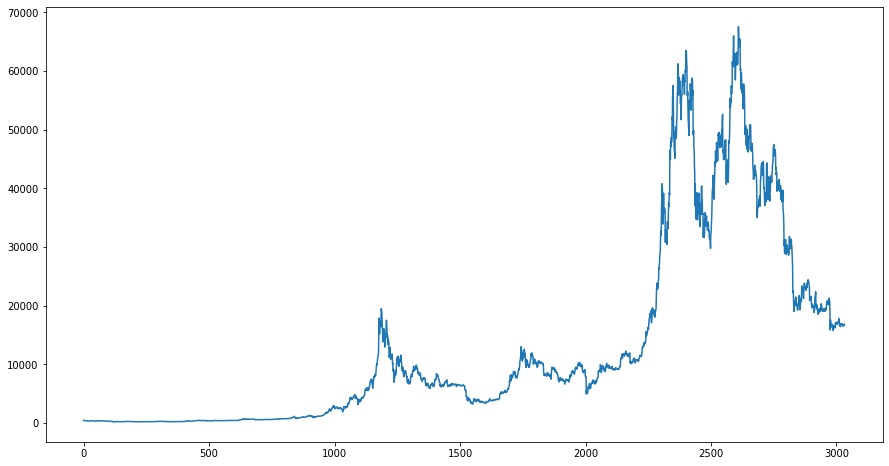

In [354]:
price = df['close']
fig = plt.figure(figsize=(15, 8))
plt.plot(price)
plt.show()

#Ajout des indicateurs techniques 
Dans cette partie nous ajoutons à notre DataFrame grâce à la librairie stockstat les indicateurs techniques suivant : 
- RSI
- Bandes de Bollinger
- MACD
- Choppiness Index
- Percentage Price Oscillator
- LazyBear's Wave Trend
- Volume Variation Index

Et nous ajoutons une colonne "change" qui représente les variations en % du prix de la paire. 

In [15]:
#create a StockDataFrame
stock_df = stockstats.StockDataFrame.retype(df, "index")

In [18]:
boll_values = stock_df.get('boll')
rsi = stock_df.get("rsi")
macd = stock_df.get('macd')
chop = stock_df.get('chop')
ppo = stock_df.get('ppo')
change = stock_df.get('change')
vr = stock_df.get('vr')
wt = stock_df.get('wt1')

In [19]:
print(stock_df)

             date          open          high           low         close  \
index                                                                       
0      2014-09-17    465.864014    468.174011    452.421997    457.334015   
1      2014-09-18    456.859985    456.859985    413.104004    424.440002   
2      2014-09-19    424.102997    427.834991    384.532013    394.795990   
3      2014-09-20    394.673004    423.295990    389.882996    408.903992   
4      2014-09-21    408.084991    412.425995    393.181000    398.821014   
...           ...           ...           ...           ...           ...   
3028   2023-01-01  16547.914063  16630.439453  16521.234375  16625.080078   
3029   2023-01-02  16625.509766  16759.343750  16572.228516  16688.470703   
3030   2023-01-03  16688.847656  16760.447266  16622.371094  16679.857422   
3031   2023-01-04  16680.205078  16964.585938  16667.763672  16863.238281   
3032   2023-01-05  16866.830078  16882.992188  16799.291016  16819.142578   

In [20]:
df['rsi'] = rsi
df['boll'] = stock_df["boll"]
df['boll_ub'] = stock_df["boll_ub"]
df['boll_lb'] = stock_df["boll_lb"]
df['rs_14'] = stock_df["rs_14"]
df['macd'] = stock_df["macd"]
df['macds'] =stock_df["macds"]
df['macdh'] = stock_df["macdh"]
df['chop'] = stock_df['chop']
df['ppo'] = stock_df['ppo']
df['ppos'] = stock_df['ppos']
df['ppoh'] = stock_df['ppoh']
df["vr"] = stock_df['vr']
df['change'] = stock_df['change']
df['wt1'] = stock_df["wt1"]
df['wt2'] = stock_df["wt2"]

Ici nous affichons les graphs de différents indicateurs pour voir s'ils sont pertinents. 

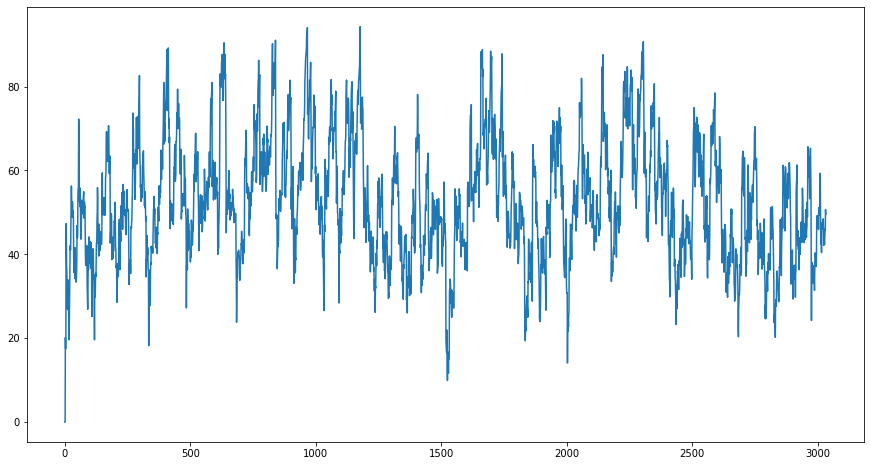

In [355]:
rsi = df['rsi']
fig = plt.figure(figsize=(15, 8))
plt.plot( rsi)
plt.show()

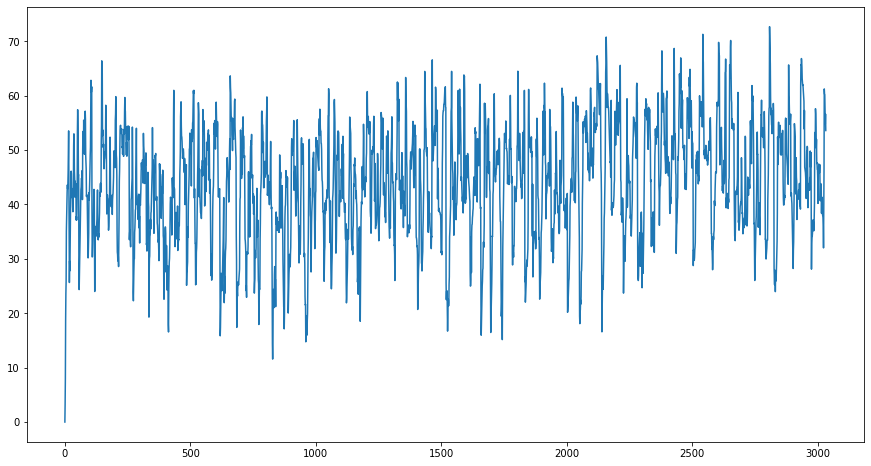

In [356]:
chop = df['chop']
fig = plt.figure(figsize=(15, 8))
plt.plot(chop)
plt.show()

#Implémentation de XgBoost

Avant d'implémenter XgBoost nous devons nettoyer notre dataset. En effet laisser des variables les variables que le l'on cherche à expliquer telles que le prix de clôture, d'ouverture, etc... ne serait pas pertinent. 

Nous utilisons XgBoost pour obtenir 2 indications: 
- une indication sur la direction de la journée
- une indication sur le pourcentage de la journée

In [358]:
X_dir = df
X_dir =X_dir[X_dir.columns.drop(list(X_dir.filter(regex='price')))]
X_dir = X_dir[X_dir.columns.drop("open")]
X_dir = X_dir[X_dir.columns.drop("close")]
X_dir = X_dir[X_dir.columns.drop("high")]
X_dir = X_dir[X_dir.columns.drop("low")]
X_dir = X_dir[X_dir.columns.drop("date")]
X_dir = X_dir[X_dir.columns.drop("change")]
y_dir = df['price_direction']

Ici nous divisons notre dataset en plusieurs parties pour entrainer et  tester notre modèle. Nous précisons que Shuffle est faux car nous souhaitons garder l'ordre de nos données. Nous cherchons pas à prédire le passé avec le futur

In [27]:
X_train_dir, X_test_dir, y_train_dir, y_test_dir = train_test_split(X_dir, y_dir, test_size=0.2, random_state=42, shuffle=False)

Nous avons tous les éléments nécessaires à la création de notre modèle, il ne nous reste plus qu'à l'optimiser. 

Pour ce faire nous allons faire une recherche par grille avec cross validation pour modifier et optimiser les hyperparamètres du modèle. 

In [359]:
bst_dir = XGBClassifier()
# Create a range of learning rates to explore
learning_rates = [0.001, 0.01, 0.1, 1.0]
max_depths = [3, 6, 10]
n_estimators = [100, 500, 1000]
colsample_bytree = [0.3, 0.7,1]
# Create a dictionary of hyperparameters to tune
param_grid = {'learning_rate': learning_rates, 'max_depth': max_depths, 'n_estimators': n_estimators, 'colsample_bytree': colsample_bytree }
# Create a grid search object
grid_search = GridSearchCV(bst_dir, param_grid, cv=5)
# Fit the grid search object to the training data
grid_search.fit(X_train_dir, y_train_dir)
# Print the best learning rate and the best model
print('Best learning rate:', grid_search.best_params_['learning_rate'])
print('Best maximum depth:', grid_search.best_params_['max_depth'])
print('Best number of estimators:', grid_search.best_params_['n_estimators'])
print('Best model:', grid_search.best_estimator_)


Best learning rate: 0.01
Best maximum depth: 6
Best number of estimators: 100
Best model: XGBClassifier(colsample_bytree=0.7, learning_rate=0.01, max_depth=6)


Donc notre meilleur modèle pour indiquer la direction prix est obtenu avec les hyperparamètres suivant: 
- learning_rate = 0.01
- max_depth = 6
- colsample_bytree = 0.7
- n_estimators = 100

In [29]:
bestmodel_dir = XGBClassifier(colsample_bytree=0.7, learning_rate=0.01, max_depth=6)
bestmodel_dir.fit(X_train_dir,y_train_dir)
predictions = bestmodel_dir.predict(X_test_dir)
accuracy = accuracy_score(y_test_dir, predictions)
print("Accuracy: {:.2f}".format(accuracy))

Accuracy: 0.69


Nous fonctionner de la même manière pour créer notre modèle prédictif sur le pourcentage de variation de la prochaine journée. 

In [360]:
X_change = df
X_change =X_change[X_change.columns.drop(list(X_change.filter(regex='price')))]
X_change = X_change[X_change.columns.drop("open")]
X_change = X_change[X_change.columns.drop("close")]
X_change = X_change[X_change.columns.drop("high")]
X_change = X_change[X_change.columns.drop("low")]
X_change = X_change[X_change.columns.drop("date")]
X_change = X_change[X_change.columns.drop("change")]
y_change = df['change']

In [32]:
X_train_change, X_test_change, y_train_change, y_test_change = train_test_split(X_change, y_change, test_size=0.2, random_state=42, shuffle=False)

In [35]:
def train_Regressor():
  bst_change = XGBRegressor()
  # Create a range of learning rates to explore
  learning_rates = [0.001, 0.01, 0.1, 1.0]
  max_depths = [3, 6, 10]
  n_estimators = [100, 500, 1000]
  colsample_bytree = [0.3, 0.7,1]
  # Create a dictionary of hyperparameters to tune
  param_grid = {'learning_rate': learning_rates, 'max_depth': max_depths, 'n_estimators': n_estimators, 'colsample_bytree': colsample_bytree }
  # Create a grid search object
  grid_search = GridSearchCV(bst_change, param_grid, cv=5)
  # Fit the grid search object to the training data
  grid_search.fit(X_train_change, y_train_change)
  # Print the best learning rate and the best model
  print('Best learning rate:', grid_search.best_params_['learning_rate'])
  print('Best maximum depth:', grid_search.best_params_['max_depth'])
  print('Best number of estimators:', grid_search.best_params_['n_estimators'])
  print('Best model:', grid_search.best_estimator_)
  return grid_search.best_estimator_

In [36]:
bestmodel_change = train_Regressor()

[13:32:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

Notre meilleur modèle pour la prédiction de la variation est obtenu avec les hyperparamètres suivant : 
- learning rate = 0.01  
- max_depth = 3   
- n_estimators = 500
- colsample_bytree = 1

In [361]:
#bestmodel_change = XGBRegressor(learning_rate=0.01, n_estimators=500)
bestmodel_change.fit(X_train_change, y_train_change)
predictions = bestmodel_change.predict(X_test_change)
accuracy = mean_squared_error(y_test_change, predictions)
print("mean squared error: {:.2f}".format(accuracy))

[18:22:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
mean squared error: 9.10


#Stratégie de trading

Dans cette partie nous allons implémenter une stratégie de trading.
L'objectif principal de cette stratégie est de ne pas perdre d'argent. Nous ne cherchons pas ici à obtenir des rendements extrêment élevés.
Notre stratégie est basée sur nos 2 modèles, et nous tradons les longs et les shorts. 

Les critères que nous prenons en compte pour ouvrir un trade sont les suivants :     
- la direction donnée par bst_dir
- la confiance du modèle dans sa prédiction
- le % de changement donné par bst_change

Nous ouvrons un trade si :    
- la confiance de bst_dir dans sa prédiction est de plus de 75%
- si bst_change nous donne une indication qui n'est pas contraire à bst_dir (par exemple bst_dir annonce une journée à la hausse, si bst_change s'attend à -3% de variation nous n'ouvrons pas de trade)

Un trade est composé des éléments suivants :     
- take-profit égal à la variation donnée par bst_change
- stop-loss égal à la bande haute/basse de Bollinger (haute = short, basse = long). Les bandes de Bollinger étant un indicateur de volatilité, il nous évite de grosse perte de capital sur des mouvements très volatils. 
- le trade est clôturé à la fin de la journée (23h59.999)

Pour savoir si cette stratégie est pertinente nous allons devoir la backtester. 
Dans ce but nous allons entrainer 2 modèles. En effet il n'est pas pertinent d'utiliser des modèles déjà entrainer sur les datas utilisées pour le baktesting.
Ainsi nous allons arbitrairement couper le dataset en 2 à partir de l'index 2500. 
Les 2500 premières valeurs serviront à l'entrainenement du modèle et les 533 autres au backtest. 

In [45]:
X_train_b_dir = X_dir.iloc[:2500]
X_test_b_dir = X_dir.iloc[2500:]

X_train_b_change = X_change.iloc[:2500]
X_test_b_change = X_change.iloc[2500:]

y_train_b_dir = y_dir.iloc[:2500]
y_test_b_dir = y_dir.iloc[2500:]

y_train_b_change = y_change.iloc[:2500]
y_test_b_change = y_change.iloc[2500:]

In [150]:
X_backtest = df.iloc[2500:]

In [66]:
print(X_train_b_change)

            volume          boll       boll_ub       boll_lb     rs_14  \
index                                                                    
0         21056800    457.334015           NaN           NaN       NaN   
1         34483200    440.887008    487.406168    394.367849  0.000000   
2         37919700    425.523336    488.089504    362.957167  0.000000   
3         36863600    421.368500    475.088945    367.648055  0.252428   
4         26580100    416.859003    467.565274    366.152731  0.211363   
...            ...           ...           ...           ...       ...   
2495   18895018942  33622.830859  36024.035822  31221.625897  0.648694   
2496   18787986667  33490.954590  35992.131691  30989.777489  0.688079   
2497   20434789545  33238.457324  35748.926484  30727.988165  0.594484   
2498   23148267245  32976.782910  35771.180993  30182.384828  0.516403   
2499   28203024559  32903.711719  35708.971376  30098.452062  0.838821   

             rsi         macd        

In [53]:
print(y_test_b_change)

index
2500    0.630357
2501    3.925483
2502    2.116920
2503    3.084476
2504    5.621887
          ...   
3028    0.468856
3029    0.381295
3030   -0.051612
3031    1.099415
3032   -0.261490
Name: change, Length: 533, dtype: float64


In [48]:
bst_change = XGBRegressor(learning_rate=0.01, n_estimators=500)
bst_change.fit(X_train_b_change, y_train_b_change)
predictions = bst_change.predict(X_test_b_change)
accuracy = mean_squared_error(y_test_b_change, predictions)
print("mean squared error: {:.2f}".format(accuracy))

[14:04:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
mean squared error: 7.84


In [145]:
bst_dir = XGBClassifier(colsample_bytree=0.7, learning_rate=0.01, max_depth=6)
bst_dir.fit(X_train_b_dir,y_train_b_dir)
predictions = bst_dir.predict(X_test_b_dir)
accuracy = accuracy_score(y_test_b_dir, predictions)
print("Accuracy: {:.2f}".format(accuracy))

Accuracy: 0.69


Nos modèles sont entrainés, testons notre stratégie. 

In [362]:
trade_date = []

def backtest_strategy(data, bst_dir, bst_change, initial_capital, trade_percentage):
  # Initialize variables
  num_trades = 0
  profits = 0
  capital = initial_capital
  trade_amount = trade_percentage * capital

  # Create an empty list to store the evolution of the profits
  evolution = []
  data_model = data
  data_model =data_model[data_model.columns.drop(list(data_model.filter(regex='price')))]
  data_model = data_model[data_model.columns.drop("open")]
  data_model = data_model[data_model.columns.drop("close")]
  data_model = data_model[data_model.columns.drop("high")]
  data_model = data_model[data_model.columns.drop("low")]
  data_model = data_model[data_model.columns.drop("date")]
  data_model = data_model[data_model.columns.drop("change")]
  # Iterate through the data
  for i in range(1, len(data)):
    # Get the predictions from the models
    direction = bst_dir.predict(data_model.iloc[i-1:i])
    dir_confidence = bst_dir.predict_proba(data_model.iloc[i-1:i])

    change = bst_change.predict(data_model.iloc[i-1:i])

    # Get the entry price
    entry_price = data['close'].iloc[i-1]

    # Calculate the order size
    order_size_btc = trade_amount / entry_price
    profit = 0
    # Check if we should open a trade
    if numpy.amax(dir_confidence) > 0.75 and direction > 0.5 and change > 0:
      # Open a long trade
      num_trades += 1
      trade_date.append(data['date'].iloc[i-1])
      capital -= trade_amount
      take_profit = entry_price*change
      stop_loss = data['boll_lb'].iloc[i-1]
      entry_price = data['close'].iloc[i-1]
      exit_price = data['close'].iloc[i]
      # Check if the trade was successful
      if exit_price > take_profit:
        profit += (take_profit-entry_price)/(entry_price)*(trade_amount)*(0.997)
      elif exit_price < stop_loss:
        profit += (stop_loss-entry_price)/(entry_price)*(trade_amount)*(0.997)
      else:
        profit += (exit_price-entry_price)/(entry_price)*(trade_amount)*(0.997)
      print("date : " +str(data['date'].iloc[i-1]))
      print("LONG")
      print("order size in BTC : " +str(order_size_btc) +" BTC")
      print("entry price : "+str(entry_price) +" $")
      print("exit_price : " +str(exit_price)+" $")
      print("profit/perte :"+str(profit)+" $")
      capital += trade_amount+profit
      profits += profit
      print("capital after this trade : " +str(capital)+" $")
      evolution.append(capital)
      trade_amount = trade_percentage * capital
    elif numpy.amax(dir_confidence) > 0.75 and direction < 0.5 and change < 0:
      # Open a short trade
      num_trades += 1
      trade_date.append(data['date'].iloc[i-1])
      capital -= trade_amount
      take_profit = entry_price*change
      stop_loss = data['boll_ub'].iloc[i-1]
      entry_price = data['close'].iloc[i-1]
      exit_price = data['close'].iloc[i]
      # Check if the trade was successful
      if exit_price < take_profit:
        profit += (entry_price-take_profit)/(entry_price)*(trade_amount)*(0.997)
        print("a"+str(profit))
      elif exit_price > stop_loss:
        profit += (entry_price-stop_loss)/(entry_price)*(trade_amount)*(0.997)
        print("b"+str(profit))
      else:
        profit = (entry_price-exit_price)/(entry_price)*(trade_amount)*(0.997)


      print("date : " +str(data['date'].iloc[i-1]))
      print("SHORT")
      print("order size in BTC : " +str(order_size_btc) +" BTC")
      print("entry price : "+str(entry_price) +" $")
      print("exit_price : " +str(exit_price)+" $")
      print("profit/perte :"+str(profit)+" $")
      # Update the capital and store the evolution of the profits
      capital += trade_amount+profit
      profits += profit
      print("capital after this trade : " +str(capital)+" $")
      evolution.append(capital)
      trade_amount = trade_percentage * capital
      print("--------------------------------------------------------")
  # Print the results
  print(f'Number of trades: {num_trades}')
  print(f'Final profits: {profits}')
  print(f'Final capital: {capital}')

  # Plot the evolution of the profits
  fig = plt.figure(figsize=(15, 8))
  plt.plot(evolution)
  plt.xlabel('Trades')
  plt.ylabel('Capital')
  plt.title('Evolution of profits')
  plt.show()

date : 2021-09-07
SHORT
order size in BTC : 0.0021362441440112875 BTC
entry price : 46811.128906 $
exit_price : 46091.390625 $
capital after this trade : 101.53292407794298 $
--------------------------------------------------------
date : 2021-09-08
SHORT
order size in BTC : 0.0022028609399967086 BTC
entry price : 46091.390625 $
exit_price : 46391.421875 $
capital after this trade : 100.8739797379038 $
--------------------------------------------------------
date : 2021-09-09
SHORT
order size in BTC : 0.0021744101745729 BTC
entry price : 46391.421875 $
exit_price : 44883.910156 $
capital after this trade : 104.14209471152503 $
--------------------------------------------------------
date : 2021-11-16
SHORT
order size in BTC : 0.0017310494956970534 BTC
entry price : 60161.246094 $
exit_price : 60368.011719 $
capital after this trade : 103.78524694523395 $
--------------------------------------------------------
date : 2022-08-18
SHORT
order size in BTC : 0.004471047133210641 BTC
entry p

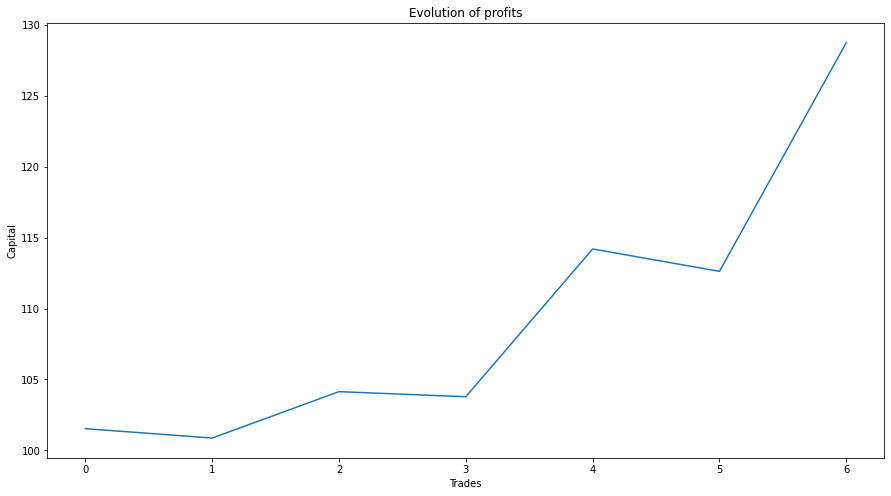

In [351]:
backtest_strategy(X_backtest,bst_dir,bst_change,100,1)

In [347]:
def plot_trade(data):
  # Extract the close price column from the dataframe
  prices = data['close'].values.tolist()
  date = data['date'].values.tolist()
  # Create a figure and an axis
  fig = plt.figure(figsize=(15, 8))

  ax = fig.add_subplot(111)
  ax.plot(prices)

  for i in range(len(trade_date)):
    for j in range(len(date)):
      if(date[j]==trade_date[i]): 
          # Plot a red dot on the graph at the index of the trade date
          ax.plot(j, prices[j], 'r^', markersize=8)


  plt.show()

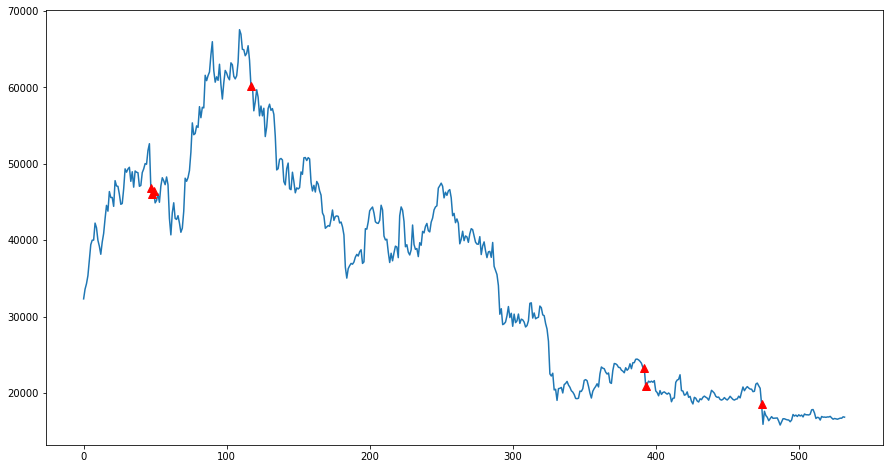

In [348]:
plot_trade(X_backtest)

Nous pouvons voir que notre approche conservatrice a payé. En effet notre stratégie nous fait gagner 28.73% sur notre capitale si nous l'utilisions à 100% pour chaque trade. Sur une période de 533 jours cela représente 19.674% par an. 
Aussi nous remarquons que cette stratégie est adaptée pour surfer des tendances, nous n'avons fait que shorter le marché dans une tendance majoritairement baissière. 

Néanmoins nous pouvons reprocher à ce backtesting que le nombre de trade est trop peu important pour valider cette stratégie, il conviendrait de la backtester sur différentes échelles de temps pour avoir plus de données. 